### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Get Data

In [17]:
train = pd.read_hdf('../wip-data/train.h5')
train = train.iloc[:, 1:] # dropping the 'Id' Column
n_train = train.shape[0]
print('The train dataset has %i records and %i features' % (train.shape[0], train.shape[1]))

test = pd.read_hdf('../wip-data/test.h5')
test_ID = test.Id
test = test.iloc[:, 1:] # dropping the 'Id' Column

SalePrice = pd.read_hdf('../wip-data/SalePrice.h5')
SP_log = np.log(SalePrice)

The train dataset has 1460 records and 337 features


### Investigating Bias-Variance Tradeoff

We investigate the bias-variance tradeoff for two tree-based ensemble models - <b>RandomForest</b> and <b>Gradient Boosted Trees</b>. For both models we plot the learning curves for increasing size of training set.

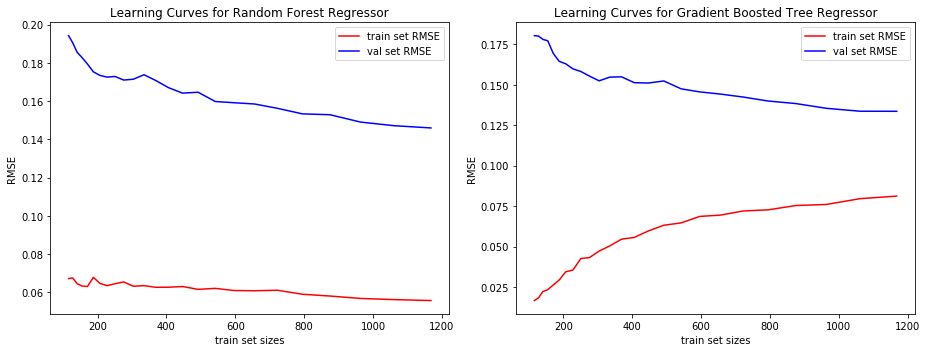

In [24]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf_est = RandomForestRegressor(random_state = 1970)
gb_est = GradientBoostingRegressor(random_state = 1970)

plt.figure(figsize = (13, 5))

plt.subplot(1, 2, 1)
train_sizes, train_scores, val_scores = learning_curve(rf_est, train, SP_log, random_state = 1970, n_jobs = -1,
                                                       scoring = 'neg_root_mean_squared_error', 
                                                       train_sizes = np.logspace(-1, 0, 25))
plt.plot(train_sizes, -train_scores.mean(axis = 1), label = 'train set RMSE', color = 'red')
plt.plot(train_sizes, -val_scores.mean(axis = 1), label = 'val set RMSE', color = 'blue')
plt.xlabel('train set sizes')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves for Random Forest Regressor')

plt.subplot(1, 2, 2)
train_sizes, train_scores, val_scores = learning_curve(gb_est, train, SP_log, random_state = 1970, n_jobs = -1,
                                                       scoring = 'neg_root_mean_squared_error', 
                                                       train_sizes = np.logspace(-1, 0, 25))
plt.plot(train_sizes, -train_scores.mean(axis = 1), label = 'train set RMSE', color = 'red')
plt.plot(train_sizes, -val_scores.mean(axis = 1), label = 'val set RMSE', color = 'blue')
plt.xlabel('train set sizes')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves for Gradient Boosted Tree Regressor')

plt.tight_layout()
plt.show()



#### Conclusions
<ul>
    <li>For both the models, the learning curves approach each other without meeting and indicate that both models are likely to suffer from variance rather than bias.
    <li>For both models, variance is reduced by:
        <ol>
            <li>decreasing the depth of the tree,
            <li>decreasing the number of trees in the ensemble, and
            <li>decreasing the number of parameters considered at each split.
        </ol>
    <li>Finally, for the Gradient Boosted Tree Ensemble, we need to pick the optimal learning rate.
</ul>

We use GridSearchCV to implement a cross-validation strategy to arrive at the optimal values for the parameters of the two models.  

### Model Evaluation
<ol>
    <li>We build <b>Random Forest Ensemble</b> and <b>Gradinet Boosted Trees Ensemble</b> regression models. For each type of model, we choose the value for the parameters that delivers the lowest 5-fold cross-validated RMSE on the <i>train</i> dataset.
    <li>We use the model with the lowest RMSE to make predictions for the <i>test</i> dataset.

In [39]:
from sklearn.model_selection import GridSearchCV

rf_param_grid = {'n_estimators' : [100, 500, 2500], 
                 'max_features' : [0.33, 0.66, 1]}
rf_mod = GridSearchCV(rf_est, param_grid = rf_param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1,
                      error_score = 'raise').fit(train, SP_log)

best_rmse = -rf_mod.best_score_
display('The best fit Random Forest Regressor reports a cross-validated RMSE of %f' % best_rmse)
display('The parameters for the best fit model are %s' % rf_mod.best_params_)

'The best fit Random Forest Regressor reports a cross-validated RMSE of 0.143264'

"The parameters for the best fit model are {'max_features': 0.33, 'n_estimators': 2500}"

In [40]:
gb_param_grid = {'n_estimators' : [100, 500, 2500], 'learning_rate' : [0.01, 0.001], 
                 'max_depth' : [1, 2, 4], 'max_features' : [0.33, 0.66, 1]}
gb_mod = GridSearchCV(gb_est, param_grid = gb_param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1, 
                      error_score = 'raise').fit(train, SP_log)

best_rmse = -gb_mod.best_score_
display('The best fit Gradient Boosted Tree Regressor reports a cross-validated RMSE of %f' % best_rmse)
display('The parameters for the best fit model are %s' % gb_mod.best_params_)

'The best fit Gradient Boosted Tree Regressor reports a cross-validated RMSE of 0.122903'

"The parameters for the best fit model are {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.33, 'n_estimators': 2500}"

#### Conclusions
<ul>
    <li>Neither the Random Forest nor the Boosted Tree Ensemble model outperforms the Ridge regression model.
</ul>